# optuna_optimiser_g_n_d_multiplier

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval
import seaborn as sns
import time
import scipy
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def error_check(params,n):
    if len(params) != n:
        raise IndexError('The number of parameters is not correct')

def generate_date_ranges_for_walk_forward(start_month_year, end_month_year, day=15, n_months = 1):
    # Initialize an empty list to store the date ranges
    date_ranges = []
    if day not in range(1, 29):
        raise ValueError('Day must be between 1 and 28')
    # Convert the input strings to datetime objects, using the given day
    start_date = datetime.strptime(f"{day} {start_month_year}", '%d %b %Y')
    end_date = datetime.strptime(f"{day} {end_month_year}", '%d %b %Y')
    
    # Generate the date ranges
    current_date = start_date
    while current_date <= end_date:
        next_date = current_date + relativedelta(months=n_months)
        date_range = [current_date.strftime('%d %b %Y'), (next_date - relativedelta(days=1)).strftime('%d %b %Y')]
        date_ranges.append(date_range)
        current_date = next_date
    
    return date_ranges[:-1]

def get_previous_n_months(end_date_str, n_months):
    # Convert the input string to a datetime object
    end_date = datetime.strptime(end_date_str, '%d %b %Y')
    
    # Calculate the start date
    start_date = end_date - relativedelta(months=n_months)
    
    # Create the date range
    date_range = [start_date.strftime('%d %b %Y'), (end_date - relativedelta(days=1)).strftime('%d %b %Y')]
    
    return date_range

In [3]:
def walk_forward_analysis(evaluation_start, evaluation_end, evaluation_day,parameters,optimization_function = None, optimizer_params =[],  lookback_in_months = 6,evaluation_period = 3):
    generated_date_ranges = generate_date_ranges_for_walk_forward(evaluation_start, evaluation_end,evaluation_day,n_months = evaluation_period)
    df = {}
    for dates in generated_date_ranges:
        train_period = get_previous_n_months(dates[0], lookback_in_months)
        train_data = data_gather_from_files(train_period[0],train_period[1])['EURUSD.mid']
        print('Data gathered for training period: ',train_period[0],train_period[1])
        test_data = data_gather_from_files(dates[0],dates[1])['EURUSD.mid']
        print('Data gathered for testing period: ',dates[0],dates[1])
        max_loss, U_PNL, max_position, R_PNL,profit,optimal_params = optimization_function(train_data,test_data,parameters,optimizer_params)
        print('Optimal parameters are: ',optimal_params)
        print('Max loss, U_PNL, max_position, R_PNL,profit are: ',max_loss, U_PNL, max_position, R_PNL,profit)
        df[dates[0] +'-'+ dates[1]] = [max_loss, U_PNL, max_position, R_PNL,profit]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'min_U_PNL', 'max_position', 'R_PNL','profit']
    return df

## Pyswarm Group 2

In [15]:
from pyswarm import pso

def pyswarm_optimiser_g_n_d_multiplier(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0] 

    error_check(parameters,5)
        
    grid_params = parameters[0]
    position_params = parameters[1]
    depth_params = parameters[2]
    multiplier_params = parameters[3]
    lookback_params = parameters[4]

    # PSO Bounds
    lb = [
        grid_params[0]/grid_params[2],
        position_params[0]/position_params[2],
        depth_params[0],
        multiplier_params[0]/ multiplier_params[2],
        0  
    ]
    ub = [
        grid_params[1]/grid_params[2],
        position_params[1]/position_params[2],
        depth_params[1],
        multiplier_params[1]/ multiplier_params[2],
        len(lookback_params) - 1
    ]
    def objective_pso(params, tick_data):

        G = int(params[0])* grid_params[2]
        n = int(params[1]) * position_params[2]
        d = int(params[2])
        multiplier = int(params[3]) *  multiplier_params[2]
        lookback_index = int(params[4])
        lookback = lookback_params[lookback_index]  
        
        max_loss,U_PNL,max_position,R_PNL,profit = run_strategy_optimised(tick_data, G, n, d, multiplier = multiplier,lookback = lookback)
        
        # Constraints
        if max_position > 10e6:
            return float('inf')
        if U_PNL < -150e3:
            return float('inf')
        if max_loss < -500e3:
            return float('inf')
        # just some bounds on the multiplier dont have to use this condition.
        if (multiplier**d)*n > 10e6:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    params_opt, _ = pso(lambda params: objective_pso(params,train_data), lb, ub, swarmsize=30, maxiter=n_trials)  

    optimal_g = int(params_opt[0])* grid_params[2]
    optimal_n = int(params_opt[1]) * position_params[2]
    optimal_d = int(params_opt[2])
    optimal_m = int(params_opt[3]) *  multiplier_params[2]
    optimal_l_index = int(params_opt[4])
    optimal_l = lookback_params[optimal_l_index]
    
    print("optimisation completed")
    max_loss, U_PNL, max_position, R_PNL,profit = run_strategy_optimised(test_data, optimal_g,optimal_n,optimal_d,multiplier = optimal_m,lookback = optimal_l)
    return max_loss, U_PNL, max_position, R_PNL,profit,[optimal_g,optimal_n,optimal_d,optimal_m,optimal_l]


In [5]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
depth_params = [3,12,1]
multiplier_params = [1,3,0.1]
lookback_params = [9,20,30,50,100,150,200]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_depth_params = ((depth_params[1]-depth_params[0])/depth_params[2])
n_multiplier_params = ((multiplier_params[1]-multiplier_params[0])/multiplier_params[2])
n_lookback_params = len(lookback_params)
print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of depth params:-',(n_depth_params))
print('number of multiplier params:-',(n_multiplier_params))
print('number of lookback params:-',(n_lookback_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_depth_params*n_multiplier_params*n_lookback_params))

n_trials = 500
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params*n_depth_params*n_multiplier_params*n_lookback_params))*100,'%')
parameters1 = [grid_params,lot_params,depth_params,multiplier_params,lookback_params]
results1 = walk_forward_analysis('jan 2021','jan 2022',1,parameters1,optimization_function=pyswarm_optimiser_g_n_d_multiplier,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results1

number of grid params:- 18.0
number of lot params:- 19.0
number of depth params:- 9.0
number of multiplier params:- 20.0
number of lookback params:- 7
total_number_of_combinations:- 430920.0
search_space_explored:- 0.11603081778520374 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
Stopping search: maximum iterations reached --> 500
optimisation completed
Optimal parameters are:  [0.0045000000000000005, 200000, 8, 1.2000000000000002, 200]
Max loss, U_PNL, max_position, R_PNL,profit are:  -10800.0 -21728.5714 2448000.0 30855.2383 54400.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
Stopping search: maximum iterations reached --> 500
optimisation completed
Optimal parameters are:  [0.0085, 1100000, 9, 1.2000000000000002, 9]
Max loss, U_PNL, max_position, R_PNL,profit are:  -168300.0 -140250.0 8078400.0 -65450.0 -65450.0
Data gathered for train

,max_loss,min_U_PNL,max_position,R_PNL,profit
01 Jan 2021-31 Mar 2021,-10800.0,-21728.5714,2448000.0,30855.2383,54400.0
01 Apr 2021-30 Jun 2021,-168300.0,-140250.0000,8078400.0,-65450.0000,-65450.0
01 Jul 2021-30 Sep 2021,0.0,-20000.0000,4760000.0,100800.0000,100800.0
01 Oct 2021-31 Dec 2021,-72000.0,-86400.0000,7200000.0,46080.0000,48960.0


In [5]:
data = data_gather_from_files('1 jul 2020','31 dec 2020')['EURUSD.mid']
run_strategy_optimised(data, 0.007, 200000, 5,multiplier=2.1,lookback=100)

(-60200.0, -47483.3333, 3718399.9999999995, 17140.4194, 136920.0)

In [ ]:
run_strategy_eval(data, 0.0045, 200000, 3,multiplier=2.3,lookback=100, trade_plot=True)

In [6]:
data = data_gather_from_files('1 oct 2020','31 mar 2021')['EURUSD.mid']
run_strategy_optimised(data, 0.009, 1300000, 8,multiplier=1,lookback=20)

(-11700.0, -99190.0, 7619949.999999999, 157950.0, 58760.0)

In [3]:
run_strategy_optimised(data, 0.0085, 1100000, 9,multiplier=1.2,lookback=9)

(-65450.0, -92565.0, 6732000.0, 112200.0001, 101310.0)

In [ ]:
run_strategy_eval(data, 0.009, 2000000, 9,multiplier=1.1,lookback=9, trade_plot=True)

In [7]:
data = data_gather_from_files('1 jan 2021','30 june 2021')['EURUSD.mid']
run_strategy_optimised(data, 0.009, 1_200_000, 5,multiplier=1.5,lookback=50)

(-21600.0, -54000.0, 5875200.0, 91200.0, 91200.0)

In [ ]:
run_strategy_eval(data, 0.01, 2_000_000, 6,multiplier=1,lookback=50, trade_plot=True)

In [11]:
data = data_gather_from_files('1 apr 2021','30 sep 2021')['EURUSD.mid']
run_strategy_optimised(data, 0.004, 100_000, 4,multiplier=2.5,lookback=9)

(-30000.0, -25700.0, 1430400.0, -27160.0002, -29920.0)

Ladderization time: 0.11275887489318848
Indicator preparation time: 0.0009999275207519531
Position sizing time: 0.0010001659393310547
PNL calculation time: 0.011002302169799805


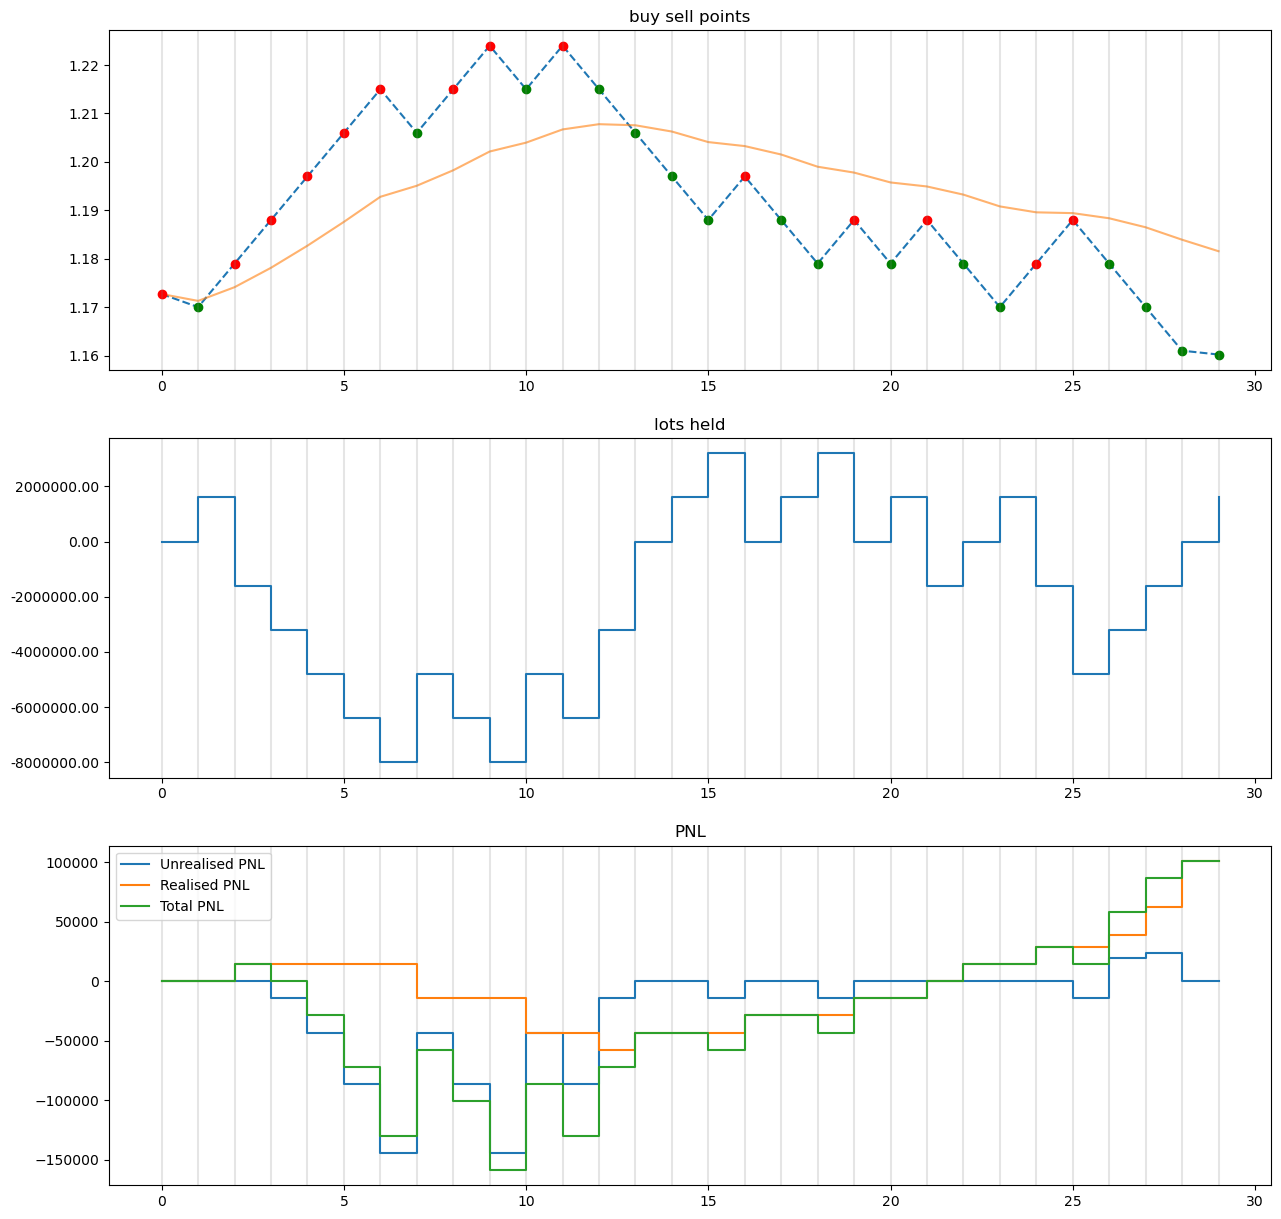

(array([      0.,       0.,   14400.,       0.,  -28800.,  -72000.,
        -129600.,  -57600., -100800., -158400.,  -86400., -129600.,
         -72000.,  -43200.,  -43200.,  -57600.,  -28800.,  -28800.,
         -43200.,  -14400.,  -14400.,      -0.,   14400.,   14400.,
          28800.,   14400.,   57600.,   86400.,  100800.,  100800.]),
 array([     0.,      0.,  14400.,  14400.,  14400.,  14400.,  14400.,
        -14400., -14400., -14400., -43200., -43200., -57600., -43200.,
        -43200., -43200., -28800., -28800., -28800., -14400., -14400.,
            -0.,  14400.,  14400.,  28800.,  28800.,  38400.,  62400.,
        100800., 100800.]),
 array([      0.,       0.,      -0.,  -14400.,  -43200.,  -86400.,
        -144000.,  -43200.,  -86400., -144000.,  -43200.,  -86400.,
         -14400.,      -0.,       0.,  -14400.,       0.,       0.,
         -14400.,       0.,       0.,      -0.,      -0.,       0.,
             -0.,  -14400.,   19200.,   24000.,      -0.,       0.]),
 arr

In [27]:
run_strategy_eval(data, 0.009, 1_600_000, 7,multiplier=1.2,lookback=20, trade_plot=True)